<a href="https://colab.research.google.com/github/hiremasa/nishika-japanese-painting-competition/blob/main/2nd_place/Notebooks/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/lukemelas/EfficientNet-PyTorch.git

fatal: destination path 'EfficientNet-PyTorch' already exists and is not an empty directory.


In [1]:
%cd /content/drive/MyDrive/nishika-japanese-painting-competition/nishika-japanese-painting-competition/2nd_place/

/content/drive/MyDrive/nishika-japanese-painting-competition/nishika-japanese-painting-competition/2nd_place


In [4]:
!pip install --upgrade efficientnet-pytorch
!pip install --upgrade timm

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=ce890df34a550c56c025043cb6157533b724f2fc36028250c5bc8ed7efc4da6d
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch
     |████████████████████████████████| 245kB 5.1MB/s 


In [5]:
import glob
import random
import numpy as np
import os
import pandas as pd
import collections
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic("matplotlib", "inline")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import timm
from timm.data import rand_augment_transform

In [7]:
seed = 42

def seed_everything(seed):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"]=str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything(seed)

current_devide = torch.cuda.current_device()
print("Devide:", torch.cuda.get_device_name(current_devide))

Devide: Tesla P4


In [11]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TRAIN_DIR = ".Datasets/data.zip (Unzipped Files)/train.zip (Unzipped Files)/train"
TEST_DIR = ".Datasets/data.zip (Unzipped Files)/test.zip (Unzipped Files)/test"
MODELS_PATH  = "./outputs/"
TRAIN_BATCH_SIZE = 20
VALID_BATCH_SIZE = 8
NUM_CLSSES = 8
USE_PRETRAINED = True
EPOCHS = 30
N_SAMPLES = 5

In [15]:
class ImageTransform():
  def __init__(self):
    self.data_transform = {
        "train": transforms.Compose([
                                     transforms.Resize(256),
                                     transforms.CenterCrop(256),
                                     transforms.RandomAffine(0.5),
                                     rand_augment_transform("rand-m15-n2-w0", hparams=None),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "test": transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(256),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
  def __call__(self, image, phase="train"):
    return self.data_transform["train"](image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


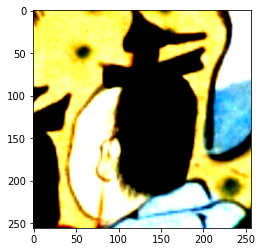

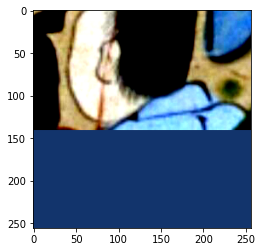

In [18]:
preview = True

if preview:
  image_file_path = "./Datasets/data.zip (Unzipped Files)/test.zip (Unzipped Files)/test/n_00000.jpg"
  img = Image.open(image_file_path)
  plt.imshow(img)

  transform = ImageTransform()

  test_transformed = transform(img, phase ="test")
  test_transformed = test_transformed.numpy().transpose((1,2,0))
  plt.imshow(test_transformed)
  plt.show()

  train_transformed = transform(img, phase ="train")
  train_transformed = train_transformed.numpy().transpose((1,2,0))
  train_transformed = np.clip(train_transformed, 0, 1)
  plt.imshow(train_transformed)
  plt.show()


In [19]:
def make_df_train_fold(n_splits=5):
  train_df = pd.read_csv("./Datasets/data.zip (Unzipped Files)/train.csv")
  train_df["kfold"] = -1
  gender_status = train_df["gender_status"].tolist()

  skf = StratifiedKFold(n_splits, shuffle=False)

  for fold, (_, val_idx) in enumerate(skf.split(range(len(gender_status))), gender_status):
    for i in val_idx:
      train_df.iat[i, 2] = fold
  return train_df